# Parabolic SAR for my portfolio

In [16]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [17]:
import datetime
import os
import time

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from modules.psar_conventional import ParabolicSAR

In [18]:
file_excel = "portfolio.xlsm"
df_portfolio = pd.read_excel(file_excel, sheet_name="Portfolio")
df_portfolio

,銘柄コード,銘柄名称,口座区分,保有数量,発注数量,平均取得価額,時価,前日比,前日比率,時価評価額,評価損益額,評価損益率,銘柄情報等,JAX時価,JNX時価,Chi-X時価,PER,PBR,配当利回り
0,147A,ソラコム,特定,100,0,880,885,83,10.35,88500,500,0.568182,-,0,885.2,887.8,79.72,3.97,0
1,2354,ＹＥＤＩＧＩＴＡＬ,特定,100,0,670,654,6,0.93,65400,-1600,-2.38806,-,0,654,0,10.13,1.76,3.06
2,2776,新都ホールディングス,特定,100,0,151,145,-2,-1.36,14500,-600,-3.97351,-,0,143.1,145.1,96.66,3.96,0
3,3010,ポラリス・ホールディングス,特定,100,0,218,217,-2,-0.91,21700,-100,-0.458716,決算,0,217,217.1,25.23,1.79,1.38
4,3660,アイスタイル,特定,100,0,560,574,30,5.51,57400,1400,2.5,決算,0,576,572.9,24.32,3.79,0.17
5,4222,児玉化学,特定,100,0,600,595,37,6.63,59500,-500,-0.833333,-,0,595,593.9,0.46,2.28,0
6,4344,ソースネクスト,特定,100,0,180,187,6,3.31,18700,700,3.888889,決算,0,186,186.5,0,3.46,0
7,4552,ＪＣＲファーマ,特定,100,0,595,598,80,15.44,59800,300,0.504202,決算,0,594,597.9,24.3,1.55,3.34
8,4891,ティムス,特定,100,0,169,170,4,2.41,17000,100,0.591716,決算,0,166,171.3,0,2.45,0
9,5016,ＪＸ金属,特定,100,0,780,826.8,2.9,0.35,82680,4680,6,決算,0,828,830.7,13.2,1.24,1.81


In [19]:
df_portfolio.columns

Index(['銘柄コード ', '銘柄名称', '口座区分', '保有数量', '発注数量', '平均取得価額', '時価', '前日比', '前日比率',
       '時価評価額', '評価損益額', '評価損益率', '銘柄情報等', 'JAX時価', 'JNX時価', 'Chi-X時価', 'PER',
       'PBR', '配当利回り'],
      dtype='object')

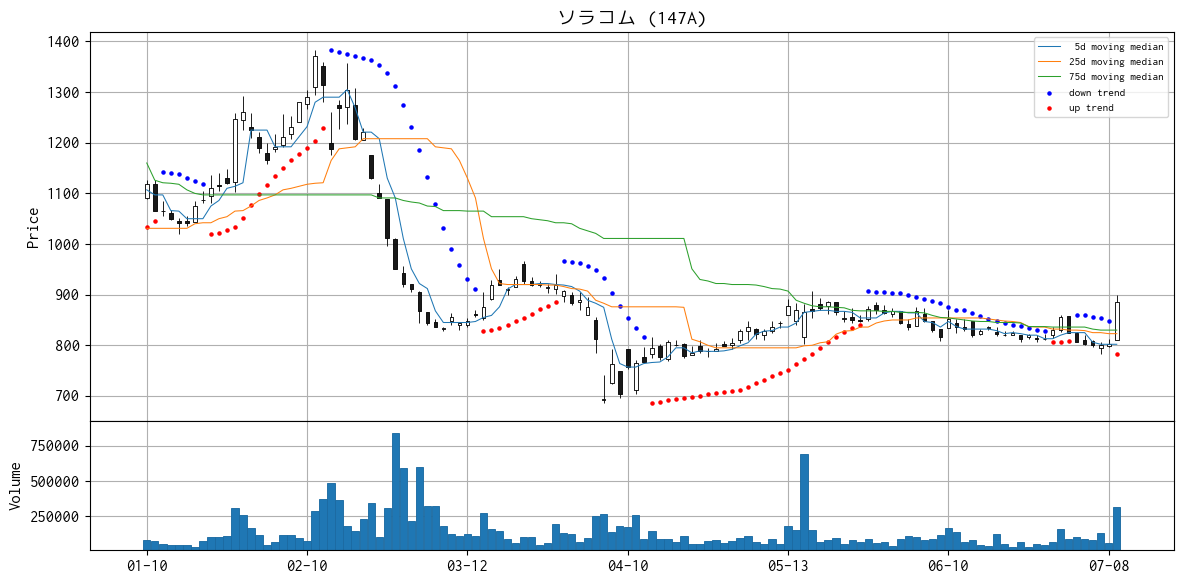

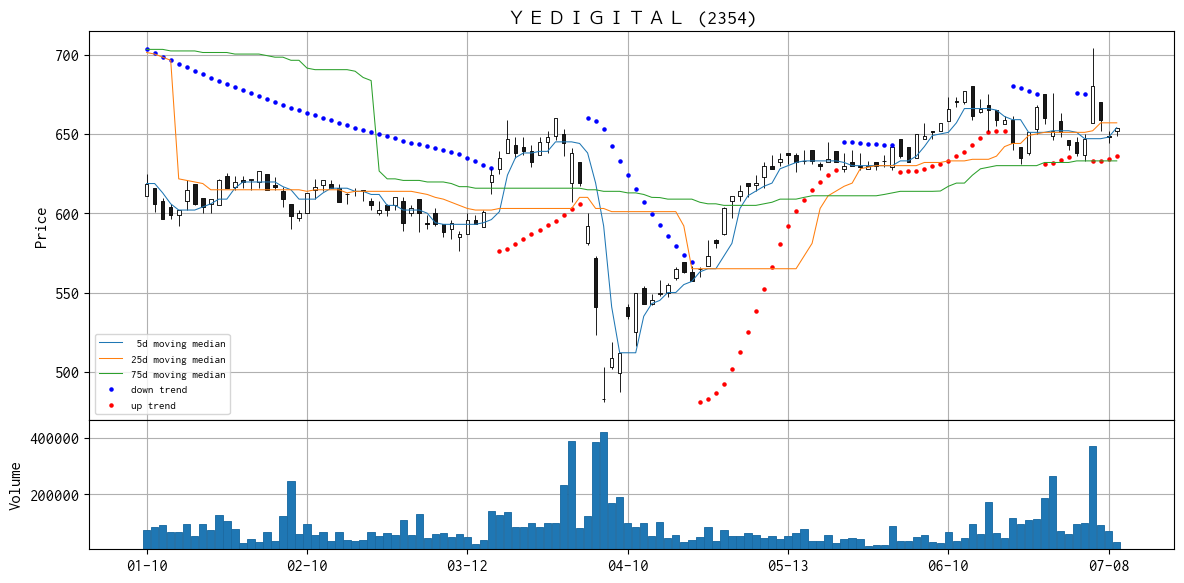

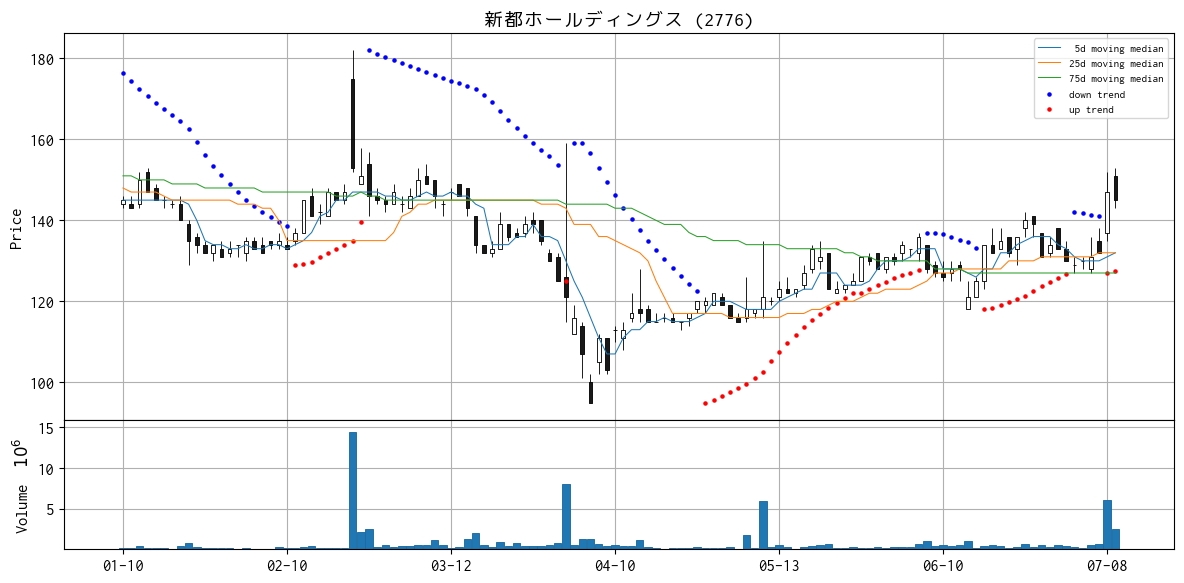

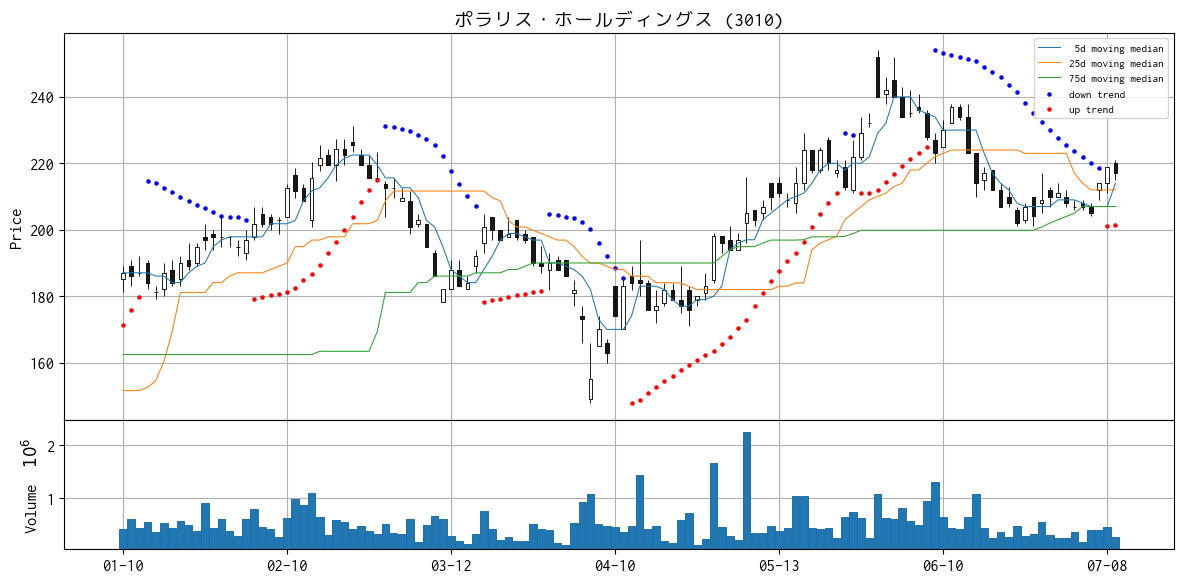

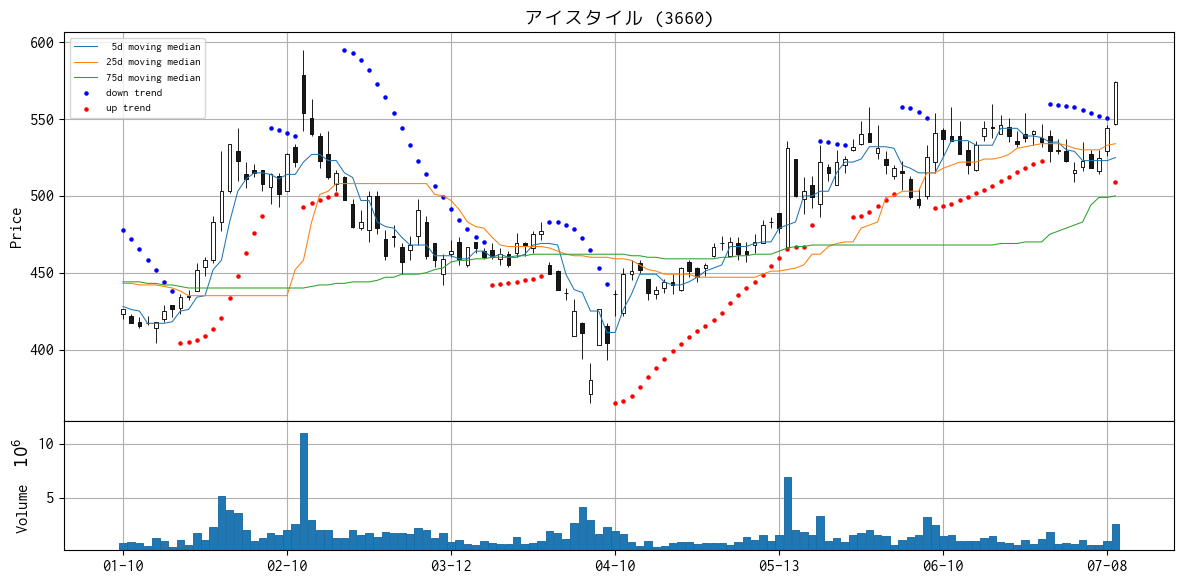

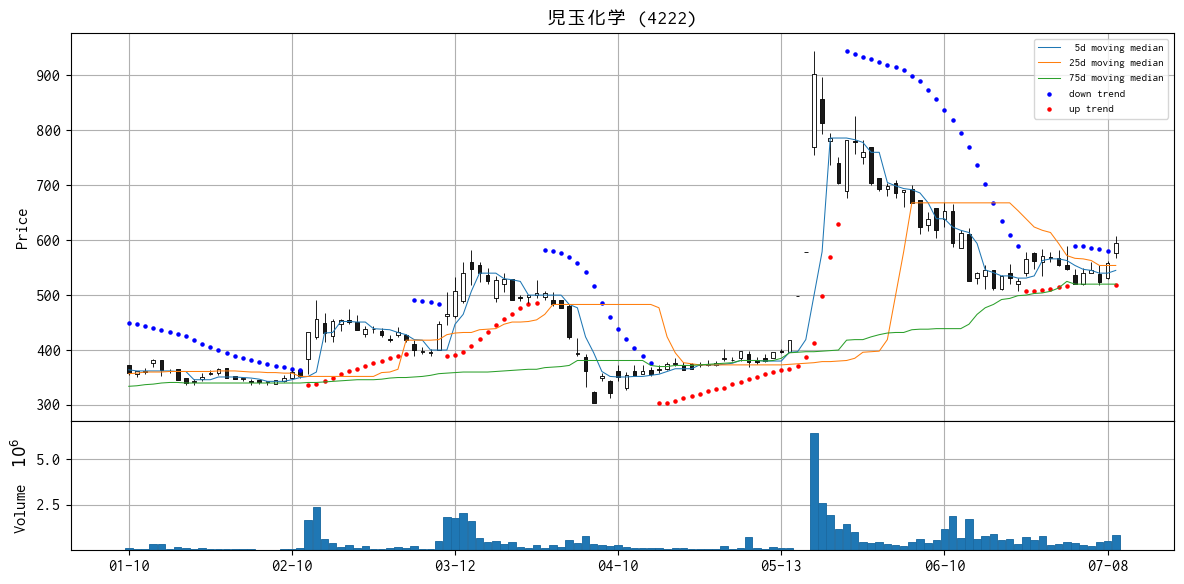

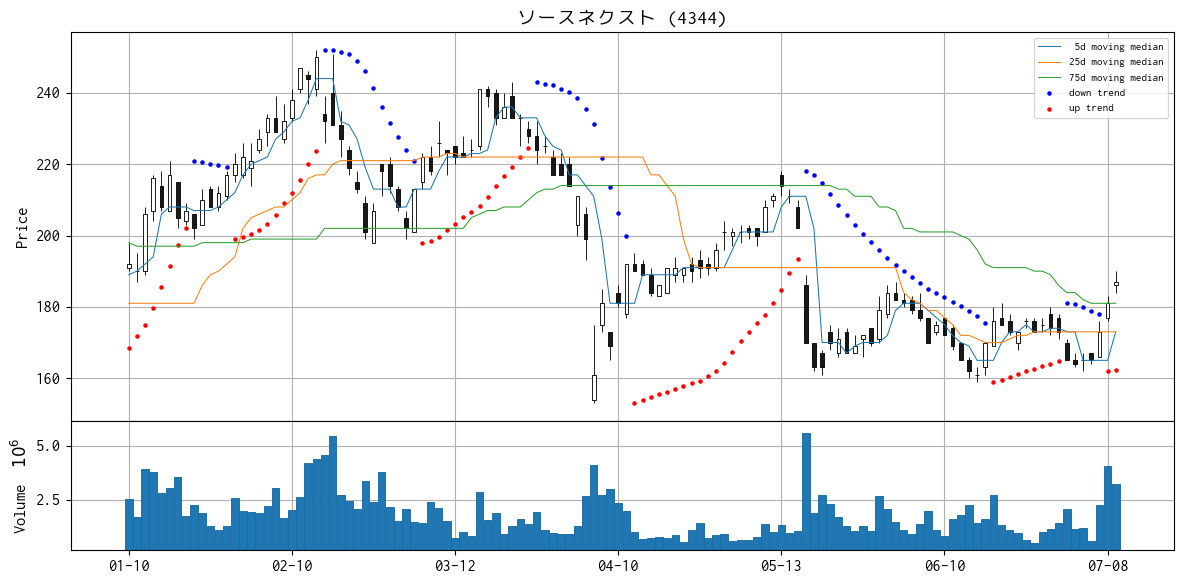

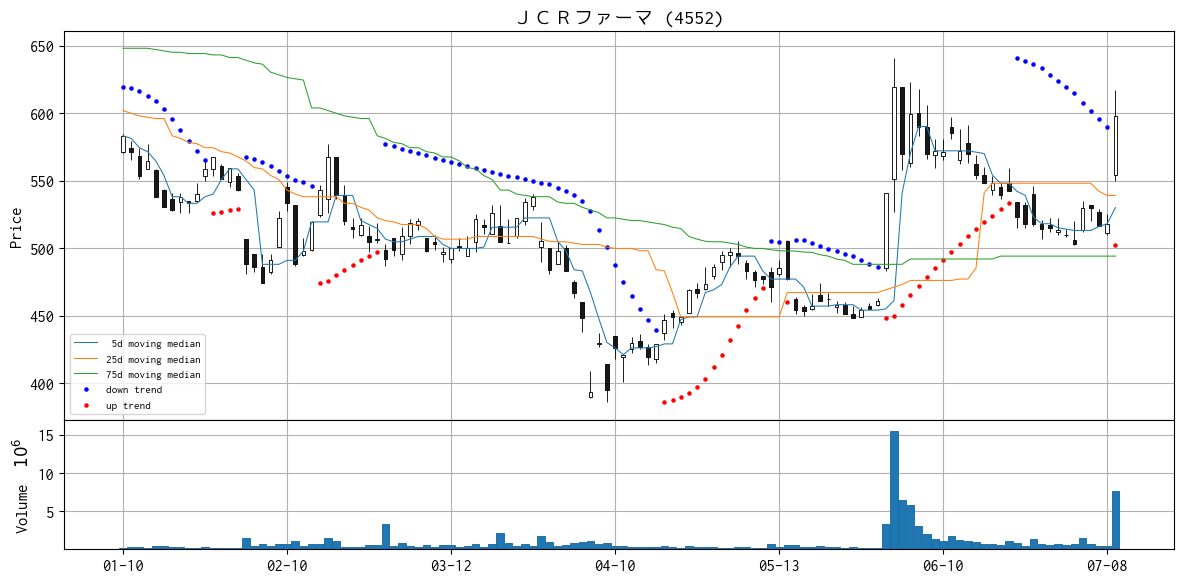

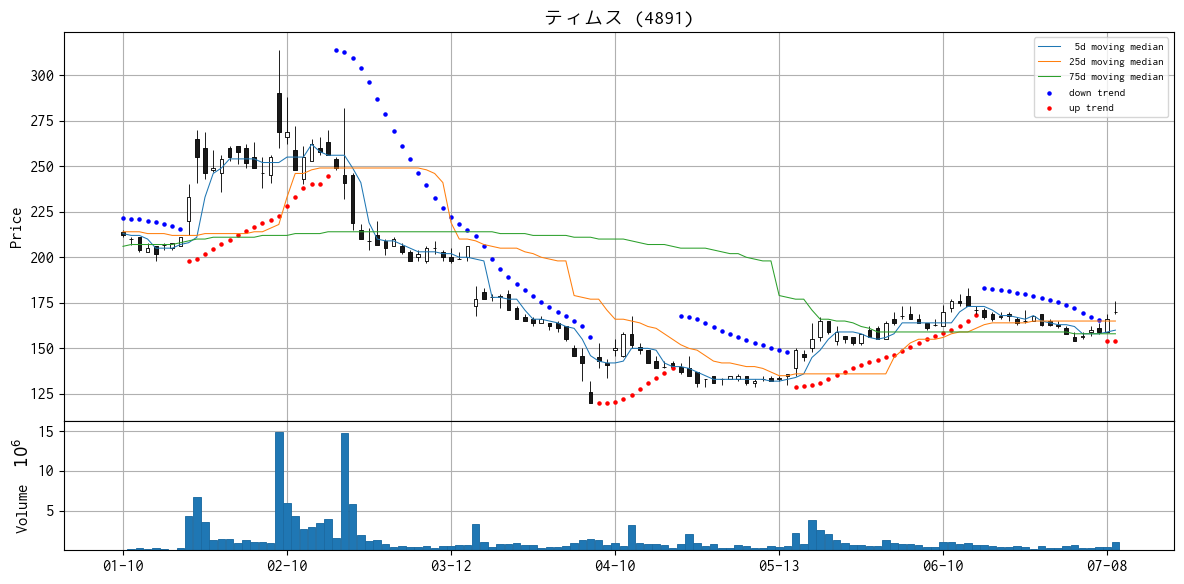

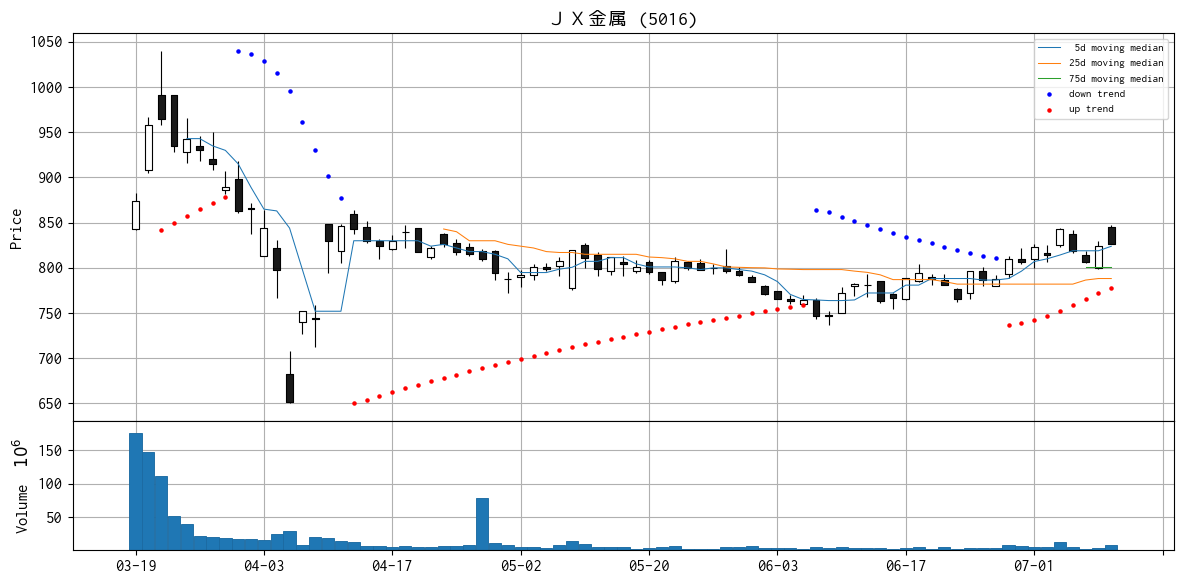

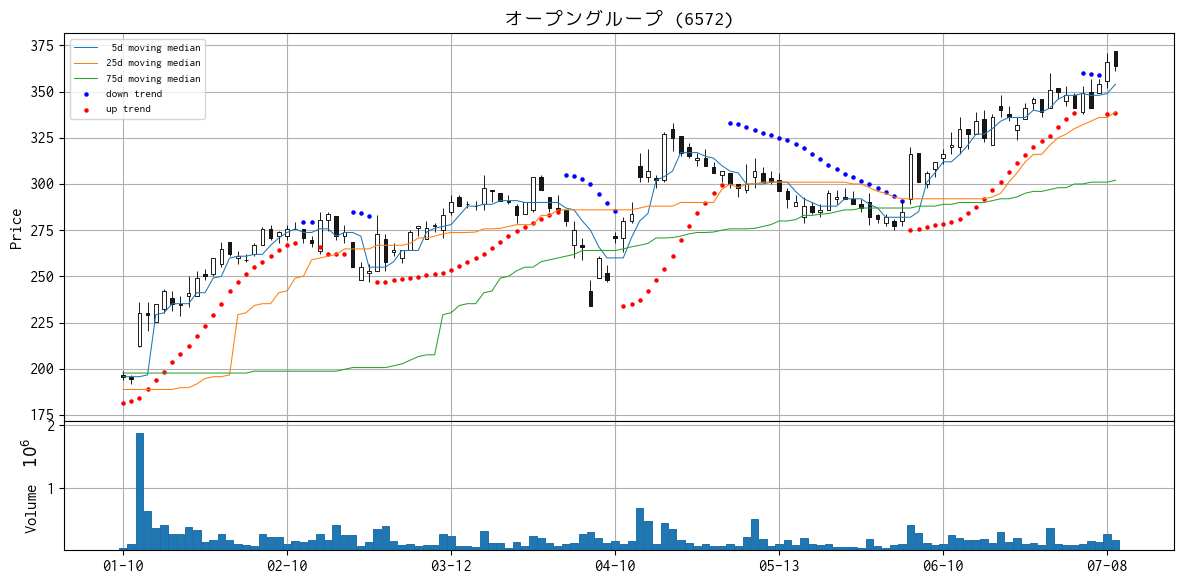

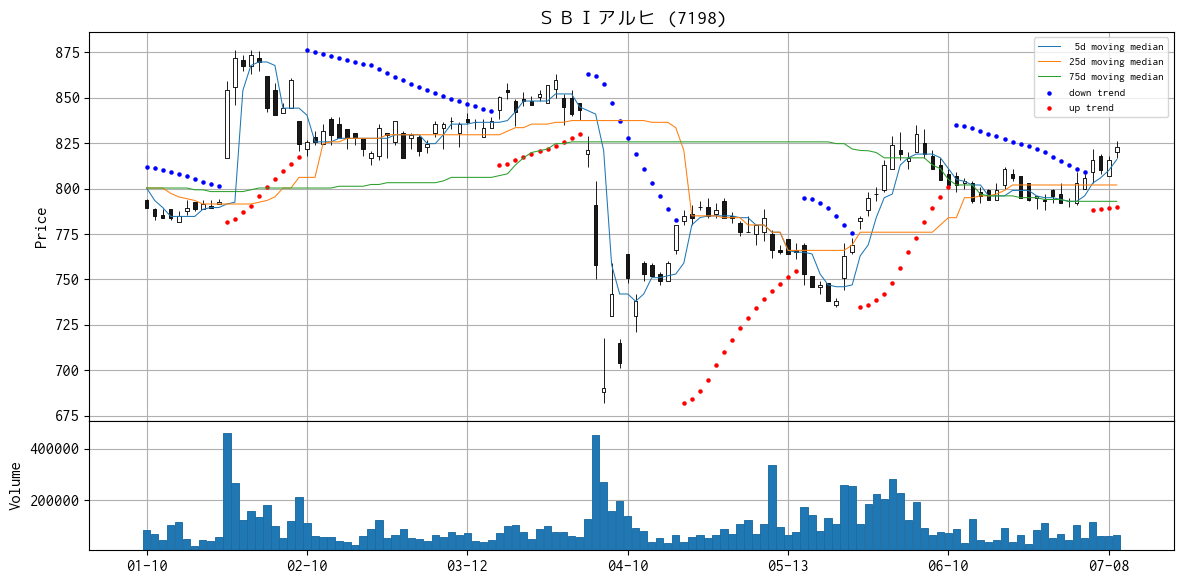

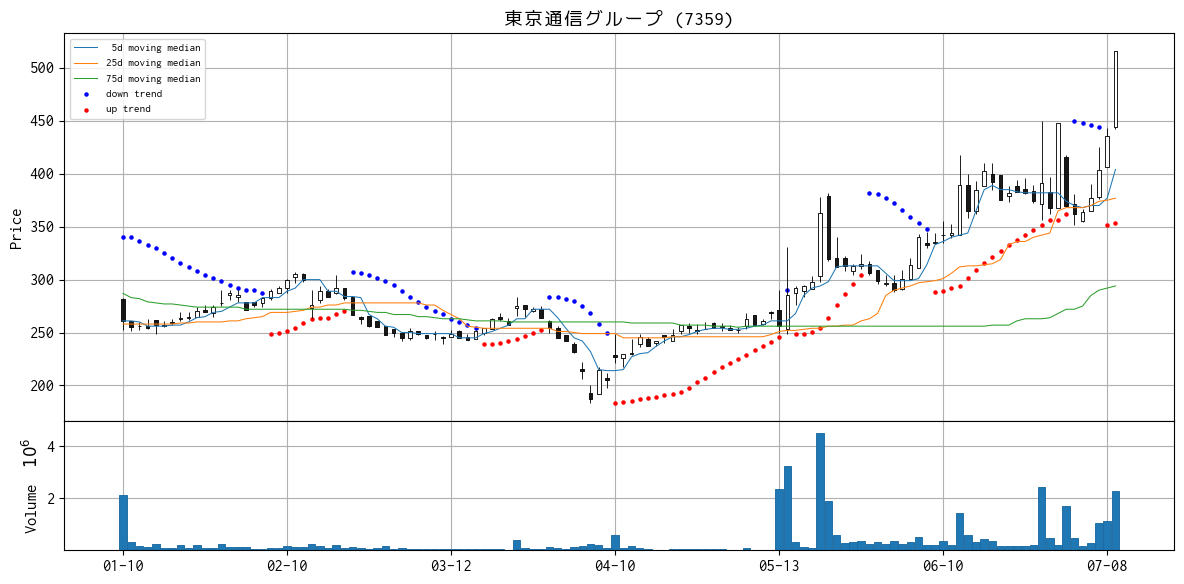

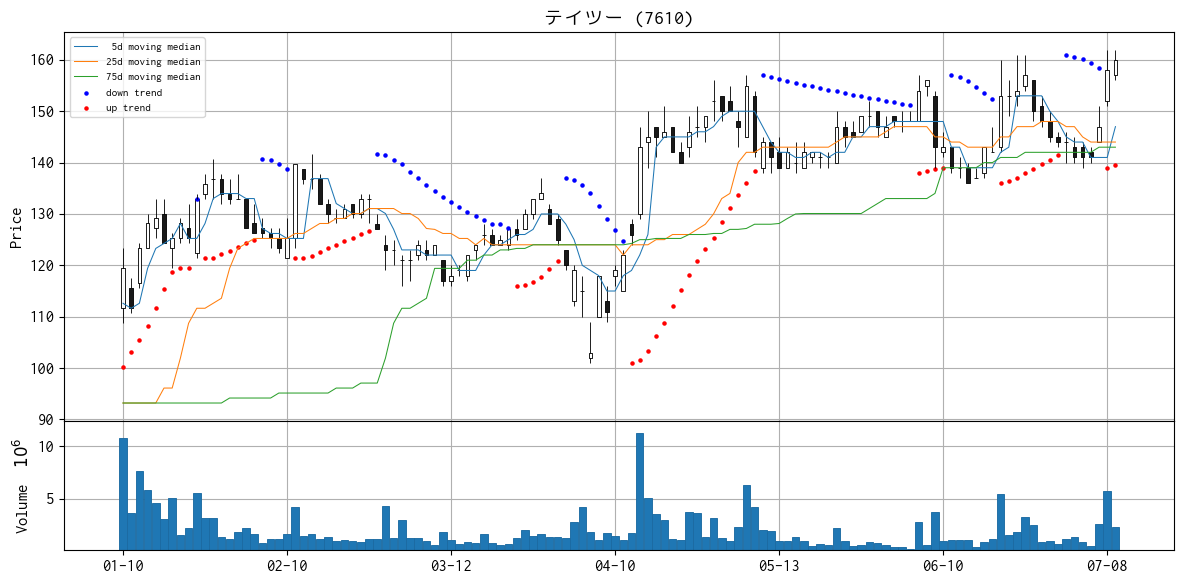

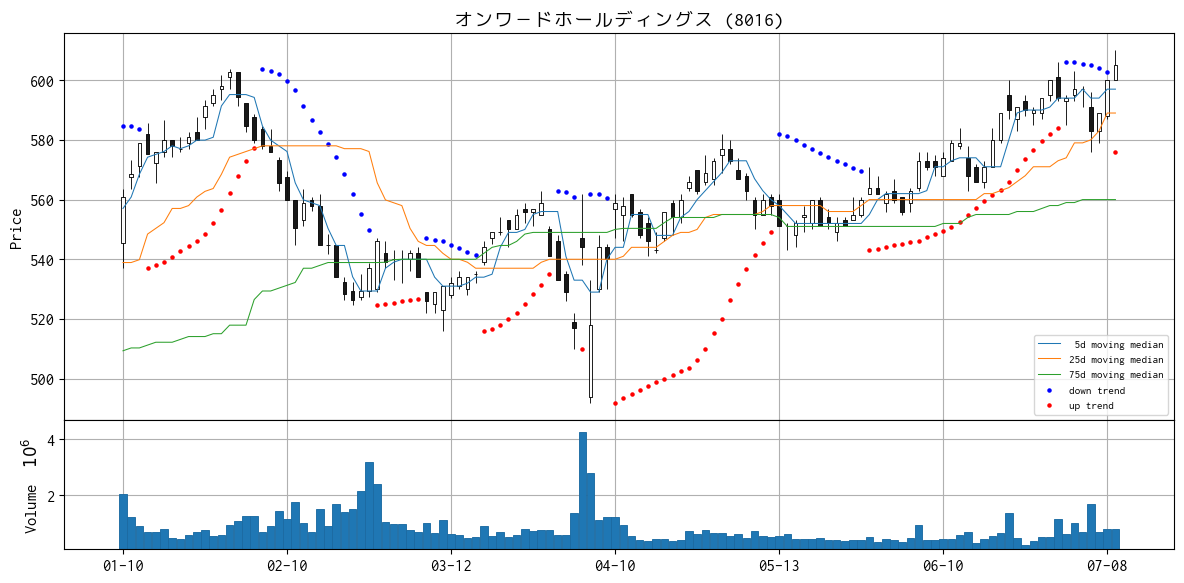

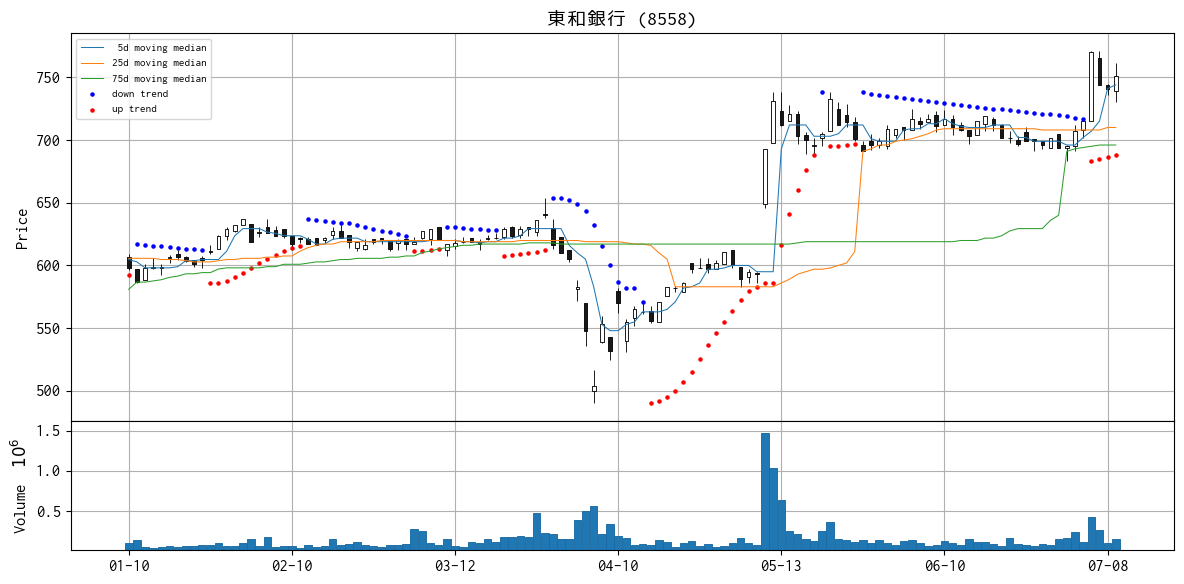

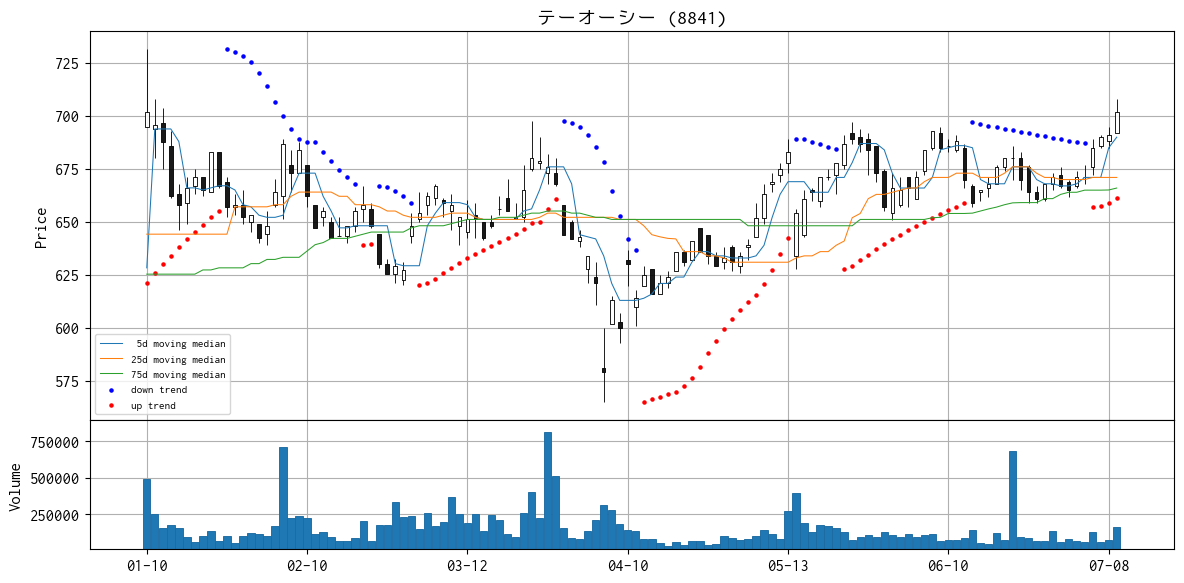

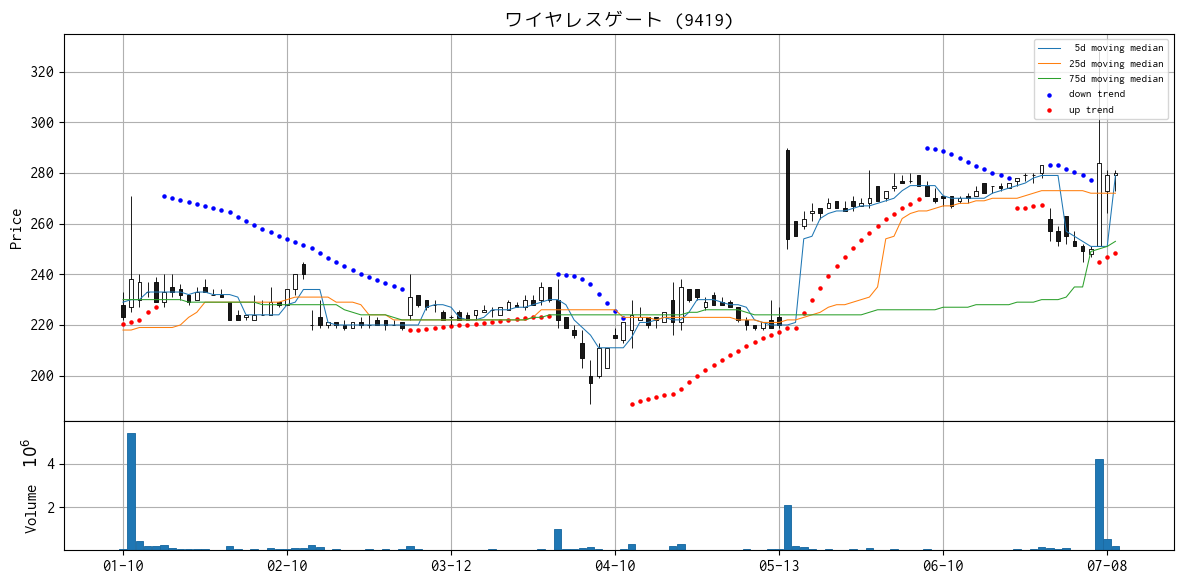

In [20]:
for r in range(len(df_portfolio)):
    code = df_portfolio.at[r, "銘柄コード "]
    if code == "--------":
        break
    name = df_portfolio.at[r, "銘柄名称"]
    symbol = f"{code}.T"
    ticker = yf.Ticker(symbol)
    df0 = ticker.history(period="3y", interval="1d")
    psar = ParabolicSAR()
    psar.calc(df0)

    # チャート
    dt_last = df0.index[len(df0) - 1]
    tdelta_1y = datetime.timedelta(days=180)
    df = df0[df0.index >= dt_last - tdelta_1y].copy()

    FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
    fm.fontManager.addfont(FONT_PATH)

    # FontPropertiesオブジェクト生成（名前の取得のため）
    font_prop = fm.FontProperties(fname=FONT_PATH)
    font_prop.get_name()

    plt.rcParams["font.family"] = font_prop.get_name()
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(12, 6))
    ax = dict()
    n = 2
    gs = fig.add_gridspec(
        n, 1, wspace=0.0, hspace=0.0, height_ratios=[3 if i == 0 else 1 for i in range(n)]
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid()

    mm05 = df0["Close"].rolling(5).median()
    mm25 = df0["Close"].rolling(25).median()
    mm75 = df0["Close"].rolling(75).median()

    apds = [
        mpf.make_addplot(mm05[df.index], width=0.75, label=" 5d moving median", ax=ax[0]),
        mpf.make_addplot(mm25[df.index], width=0.75, label="25d moving median", ax=ax[0]),
        mpf.make_addplot(mm75[df.index], width=0.75, label="75d moving median", ax=ax[0]),
        mpf.make_addplot(df["Bear"], type="scatter", marker="o", markersize=5, color="blue", label="down trend", ax=ax[0]),
        mpf.make_addplot(df["Bull"], type="scatter", marker="o", markersize=5, color="red", label="up trend", ax=ax[0]),
    ]
    mpf.plot(df, type="candle", style="default", volume=ax[1], datetime_format="%m-%d", addplot=apds, xrotation=0, ax=ax[0])
    ax[0].set_title(f"{name} ({code})")
    ax[0].legend(loc="best", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close()